In [1]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max
import json
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import skimage as sk
import scipy as sci
from scipy.interpolate import RegularGridInterpolator
import skimage.io as io
from scipy import ndimage
from matplotlib.path import Path
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors
import cv2

Code to find corresponding points


In [2]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method="eps", sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (
        (coords[:, 0] > edge)
        & (coords[:, 0] < im.shape[0] - edge)
        & (coords[:, 1] > edge)
        & (coords[:, 1] < im.shape[1] - edge)
    )
    coords = coords[mask].T
    return h, coords

def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """

    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert (dimx == dimc, "Data dimension does not match dimension of centers")

    return (
        (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T
        + np.ones((ndata, 1)) * np.sum((c**2).T, axis=0)
        - 2 * np.inner(x, c)
    )

def anms(coords, threshold, h):
    r = np.empty((coords.shape[1]))
    for i in range(0, coords.shape[1]):
        currH = h[coords[0, i], coords[1, i]]

        # start = timer()
        filteredY = coords[0][currH < threshold * h[coords[0], coords[1]]]
        filteredX = coords[1][currH < threshold * h[coords[0], coords[1]]]
        filteredCoords = np.array([filteredY, filteredX])

        filteredCoords[0] = np.square((coords[0, i] - filteredCoords[0]))
        filteredCoords[1] = np.square((coords[1, i] - filteredCoords[1]))

        sqDistances = filteredCoords[0] + filteredCoords[1]

        r[i] = float("inf") if len(sqDistances) == 0 else np.min(sqDistances)
        # r[i] = 0 if len(sqDistances) == 0 else np.min(sqDistances)
        # end = timer()
        # print(f"seq: {end-start}")
        # print(i)
        # print()

    return np.argsort(-r)

def findKeypoints(im, anmsThresh, numPoints):
    h, coords = get_harris_corners(im)
    # print(h.shape)
    # print(coords.shape)
    r = anms(coords[:], anmsThresh, h)
    topr = r[:numPoints]
    topCoords = coords[:, topr]
    topCoords = topCoords.swapaxes(0, 1)
    return topCoords

def featureDescriptors(im, coords, descriptorWidth, downSampleRatio, flatten=False):
    # Dont have to worry about edge coords bc of the harrison corner function

    descriptor = np.empty((coords.shape[0], descriptorWidth, descriptorWidth))
    reducedImg = sk.transform.downscale_local_mean(im, downSampleRatio)
    reducedCoords = np.floor_divide(coords, downSampleRatio)
    # print(reducedImg.shape)

    # print(reducedCoords)
    for i in range(coords.shape[0]):
        y, x = reducedCoords[i, 0], reducedCoords[i, 1]
        # print(f"[{y - (descriptorWidth // 2)} : {y + (descriptorWidth - (descriptorWidth // 2))},{x - (descriptorWidth // 2)} : {x + (descriptorWidth - (descriptorWidth // 2))}]")
        # print(y - (descriptorWidth // 2))
        # print(y + (descriptorWidth - (descriptorWidth // 2)))
        # print(x - (descriptorWidth // 2))
        # print(x + (descriptorWidth - (descriptorWidth // 2)))
        descriptor[i] = reducedImg[
            y - (descriptorWidth // 2) : y + (descriptorWidth - (descriptorWidth // 2)),
            x - (descriptorWidth // 2) : x + (descriptorWidth - (descriptorWidth // 2)),
        ]

        descriptor[i] = (descriptor[i] - np.mean(descriptor[i])) / np.std(descriptor[i])

    if flatten:
        descriptor = np.reshape(
            descriptor, (descriptor.shape[0], descriptor.shape[1] ** 2)
        )
    return descriptor

<>:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\16690\AppData\Local\Temp\ipykernel_7504\1674258093.py:47: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (dimx == dimc, "Data dimension does not match dimension of centers")


TODO: Code to find pixle points on image into 3D points in space


Code for calculating transform from points


In [7]:
def rigid_transform_3D(A, B):
    # Input: expects 3xN matrix of points
    # Returns R,t
    # R = 3x3 rotation matrix
    # t = 3x1 column vector
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    # if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def calcH(im1Pt, im2Pt):
    """
    Finds the H transformation matrix using least squares for im1 and im2 points.

    Args:
        im1Pt (Nx3 np.array): im1 correspondances
        im2Pt (Nx3 np.array): im2 correspondances

    Returns:
        h (3x3 np.array): Linear solution of the transformation matrix
    """
    R, t = rigid_transform_3D(im1Pt.T, im2Pt.T)

    h = np.identity(4)

    h[0:3, 0:3] = R
    h[0:3, 3] = t.flatten()

    return h


def transformPoints(points, H):
    """
    Divides out W term in transformed points

    Args:
        points (Nx3 np.array): x,y,z coordinates of points
        H (4x4 np.array): Transformation Matrix

    Returns:
        result (Nx3 np.array): Original points transformed by H
    """
    ones = np.ones((points.shape[0], 1))
    homogPoints = np.append(points, ones, 1)
    transformedPoints = np.array([H @ p for p in homogPoints])
    return transformedPoints[:, 0:3]

def ransac(im1Coords, im2Coords, iterations, percentage, inlierTolerance=0.1):
    # Stops when either iterations are met, or if a percentage of the coords are in the inlier set
    largestInlier = []
    bestH = None
    rng = np.random.default_rng(12345)
    for i in range(iterations):
        rints = rng.integers(low=0, high=len(im1Coords) - 1, size=4)
        # print(rints)
        # print(im1Coords[rints], im2Coords[rints])
        H = calcH(im1Coords[rints], im2Coords[rints])
        guessCoords = transformPoints(im1Coords, H)
        distances = np.linalg.norm(guessCoords - im2Coords, axis=1)
        # print(distances.shape)
        # print(distances)
        inlier = np.argwhere(distances < inlierTolerance)
        if inlier.shape[0] > len(largestInlier):
            largestInlier = list(inlier[:, 0])
            print(
                f"{i}: {len(largestInlier)}, ({len(largestInlier)/im1Coords.shape[0]*100}%)"
            )
            if len(largestInlier) / im1Coords.shape[0] >= percentage:
                im1RANSACPts = im1Coords[largestInlier, :]
                im2RANSACPts = im2Coords[largestInlier, :]
                bestH = calcH(im1RANSACPts, im2RANSACPts)
                return largestInlier, bestH

    im1RANSACPts = im1Coords[largestInlier, :]
    im2RANSACPts = im2Coords[largestInlier, :]
    bestH = calcH(im1RANSACPts, im2RANSACPts)
    
    return largestInlier, bestH

In [4]:
im1 = ndimage.rotate(io.imread("../../Assets/inside/inside1_Color.png"), 0)
im2 = ndimage.rotate(io.imread("../../Assets/inside/inside2_Color.png"), 0)

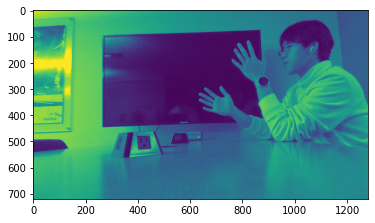

In [5]:
im1Grey = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2Grey = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
plt.imshow(im1Grey)

In [6]:
h, pointsim1 = get_harris_corners(im1Grey, edge_discard=20)
h, pointsim2 = get_harris_corners(im2Grey)

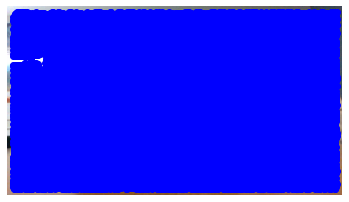

In [7]:
plt.imshow(im1)
plt.axis("off")

plt.plot(pointsim1[1, :], pointsim1[0, :], "bo")
plt.savefig("../../Assets/resultsPt2/harrisCorners.jpg", bbox_inches="tight", dpi=1000)

In [8]:
im1CoordGrey = findKeypoints(im1Grey, 0.9, 200)
im2CoordGrey = findKeypoints(im2Grey, 0.9, 200)

KeyboardInterrupt: 

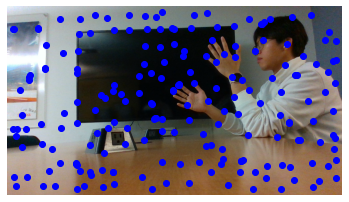

In [9]:
plt.imshow(im1)
plt.axis("off")

plt.plot(im1CoordGrey[:, 1], im1CoordGrey[:, 0], "bo")
plt.savefig("../../Assets/resultsPt2/im1ANMS80.jpg", bbox_inches="tight", dpi=1000)

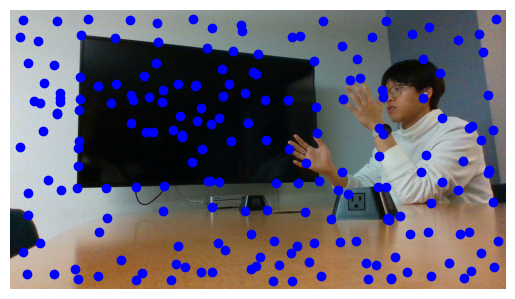

In [35]:
plt.imshow(im2)
plt.axis("off")

plt.plot(im2CoordGrey[:, 1], im2CoordGrey[:, 0], "bo")

In [45]:
descriptorim1Color = featureDescriptors(im1Grey, im1CoordGrey, 8, 5, True)
descriptorim2Color = featureDescriptors(im2Grey, im2CoordGrey, 8, 5, True)
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(descriptorim2Color)
distances, indices = nbrs.kneighbors(descriptorim1Color)
selectedPoints = np.argwhere((distances[:, 0] / distances[:, 1]) < 0.70)
print(selectedPoints.T)

[[  6  16  19  24  69 125 136]]


In [46]:
keyPointsIm1 = im1CoordGrey[selectedPoints.T][0]
keyPointsIm2 = im2CoordGrey[indices[selectedPoints.T, 0]][0]

print(keyPointsIm1.shape, keyPointsIm2.shape)

shiftedKeypointsIm2 = keyPointsIm2.copy()
shiftedKeypointsIm2[:, 0] = shiftedKeypointsIm2[:, 0] + im1.shape[0]
combinedIm = np.vstack([im1, im2])

(7, 2) (7, 2)


Start here


In [20]:
im1 = ndimage.rotate(io.imread("../../Assets/inside/inside1_Color.png"), 0)
im2 = ndimage.rotate(io.imread("../../Assets/inside/inside2_Color.png"), 0)
with open("../../Assets/inside/inside1_Color_inside2_Color.json") as jsonFile:
    keyPoints = json.load(jsonFile)
keyPointsIm1 = np.flip(np.array(keyPoints["im1Points"]),1)
keyPointsIm2 = np.flip(np.array(keyPoints["im2Points"]),1)

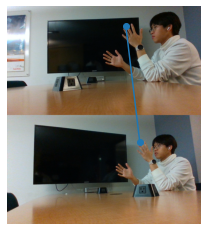

In [53]:
combinedIm = np.vstack([im1, im2])
shiftedKeypointsIm2 = keyPointsIm2.copy()
shiftedKeypointsIm2[:, 0] = shiftedKeypointsIm2[:, 0] + im1.shape[0]
plt.imshow(combinedIm)
plt.axis("off")
point = 12
plt.plot(
    np.vstack([keyPointsIm1[point, 1], shiftedKeypointsIm2[point, 1]]),
    np.vstack([keyPointsIm1[point, 0], shiftedKeypointsIm2[point, 0]]),
    "-o",
)
plt.savefig("../../Assets/resultsPt2/keypoints0_75Lowes.jpg", bbox_inches="tight", dpi=1000)

In [37]:
keyPointsIm1[2].shape, keyPointsIm1[4:].shape

((2,), (9, 2))

In [43]:
# list(keyPointsIm1[2])
keyPointsIm1Filtered = np.concatenate(([keyPointsIm1[2]], keyPointsIm1[4:]), axis=0)
print(keyPointsIm1Filtered)

keyPointsIm2Filtered = np.concatenate(([keyPointsIm2[2]], keyPointsIm2[4:]), axis=0)

[[ 295  719]
 [ 145 1070]
 [  75  869]
 [  98  267]
 [ 446  268]
 [ 442  405]
 [ 439  482]
 [ 437  502]
 [ 318  637]
 [ 128  785]]


In [27]:
keyPointsIm1Filtered.shape

(2,)

In [44]:
#TODO: Change pixle points to homogenous points in 3D space
from convertPixelTo3D import map2DTo3D, main, readInstantImage, loadCameraConfig
from getCameraConfig import saveCameraConfig

depth_img_resolution = (1280, 720)

print("----- Run the camera, save the stream intrinsic parameters -----")
# saveCameraConfig(depth_stream_width=640, depth_stream_height=480)
intrinsic_matrix = loadCameraConfig()

print("\n----- Read images -----")
depth_img_path_1 = '../../Assets/inside/inside1_Depth.raw'
rgb_img_path_1 = '../../Assets/inside/inside1_Color.png'
rgb_img_1, depth_img_1 = readInstantImage(rgb_img_path_1, depth_img_path_1, depth_img_width=1280, depth_img_height=720, display=False)

depth_img_path_2 = '../../Assets/inside/inside2_Depth.raw'
rgb_img_path_2 = '../../Assets/inside/inside2_Color.png'
rgb_img_2, depth_img_2 = readInstantImage(rgb_img_path_2, depth_img_path_2, depth_img_width=1280, depth_img_height=720, display=False)



print("\n----- Map 2D to 3D -----")
homogenous_point_img_1, zero_coord_number_1 = map2DTo3D(rgb_img_1, depth_img_1, keyPointsIm1Filtered, intrinsic_matrix)
homogenous_point_img_2, zero_coord_number_2 = map2DTo3D(rgb_img_2, depth_img_2, keyPointsIm2Filtered, intrinsic_matrix)
print(f'Valid matched points of img_1 are {len(homogenous_point_img_1)}, invalid ones are {zero_coord_number_1}')
print(f'Valid matched points of img_2 are {len(homogenous_point_img_2)}, invalid ones are {zero_coord_number_2}')
print(homogenous_point_img_1.shape)

----- Run the camera, save the stream intrinsic parameters -----

----- Read images -----
RGB image shape: (720, 1280, 3)
Depth image shape: (720, 1280)
RGB image shape: (720, 1280, 3)
Depth image shape: (720, 1280)

----- Map 2D to 3D -----
Valid matched points of img_1 are 10, invalid ones are 0
Valid matched points of img_2 are 10, invalid ones are 0
(10, 3)


In [9]:
print(homogenous_point_img_1)
print(homogenous_point_img_2)

[[-0.35433632  1.40382051  1.04100001]
 [-0.13760558  2.31223702  1.87300003]
 [-0.84578174  3.92367768  1.83000004]
 [-1.37531507  3.46881604  2.13700008]
 [-1.33670938  0.14467297  2.28900003]
 [ 0.68492621  0.14178813  2.15499997]
 [ 0.16480158  0.22555672  0.53600001]
 [ 0.15793741  0.32692522  0.52700001]
 [ 0.16109627  0.36768201  0.54699999]
 [-0.02525024  1.86109138  1.82099998]
 [-1.08889937  3.02331901  2.15100002]]
[[-0.3837755   2.47251463  1.33000004]
 [-0.00812139  3.27287936  2.31999993]
 [ 0.23153114  1.58144259  1.24699998]
 [-0.50985271  3.99532366  1.85000002]
 [-1.23068595  3.47028136  2.4690001 ]
 [-1.25880218 -0.28932756  1.87300003]
 [ 0.40754765 -0.20766486  1.16799998]
 [ 0.62825429  0.37789458  1.81400001]
 [ 0.63508791  0.79177892  1.90499997]
 [ 0.61427349  0.88732141  1.85699999]
 [ 0.06127877  1.56864429  1.26800001]
 [-0.9638989   4.30240917  2.61299992]]


In [51]:
rigid_transform_3D(homogenous_point_img_1.T, homogenous_point_img_2.T)

det(R) < R, reflection detected!, correcting for it ...


(array([[ 0.85323088,  0.05106166, -0.51902772],
        [-0.11384621,  0.98943053, -0.08981243],
        [ 0.5089559 ,  0.13572008,  0.85002586]]),
 array([[0.89098598],
        [0.35511998],
        [0.53596936]]))

## Method 1


In [ ]:
# im1Pts = np.stack([keyPointsIm1[:, 1], keyPointsIm1[:, 0]], axis=1)
# im2Pts = np.stack([keyPointsIm2[:, 1], keyPointsIm2[:, 0]], axis=1)
largestInlier, bestH = ransac(homogenous_point_img_1, homogenous_point_img_2, 1000, 0.9, 0.8)

# im1RANSACPts = im1Pts[largestInlier, :]
# im2RANSACPts = im2Pts[largestInlier, :]

det(R) < R, reflection detected!, correcting for it ...
0: 5, (50.0%)
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
6: 7, (70.0%)
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflection detected!, correcting for it ...
det(R) < R, reflecti

In [48]:
print("\n----- The transformation matrix -----")
print(bestH)


----- The transformation matrix -----
[[ 0.96954887 -0.1937973   0.14972507  0.46372139]
 [ 0.1155433   0.90104051  0.4180619   0.16127515]
 [-0.21592762 -0.38803172  0.89599478  1.55450494]
 [ 0.          0.          0.          1.        ]]


## Method 2: Least square


In [55]:
import numpy as np

def calculate_transformation_matrix(points1, points2):
    """
    Calculate the rigid transformation matrix (R, T) that aligns points1 to points2.
    Uses the Umeyama algorithm.
    
    Parameters:
    points1: np.array of shape (N, 3) - Source points
    points2: np.array of shape (N, 3) - Target points
    
    Returns:
    transformation_matrix: np.array of shape (4, 4) - Homogeneous transformation matrix
    """
    assert points1.shape == points2.shape, "Both point sets must have the same shape."

    # Compute centroids
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)

    # Center the points
    centered_points1 = points1 - centroid1
    centered_points2 = points2 - centroid2

    # Compute covariance matrix
    H = centered_points1.T @ centered_points2

    # Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Ensure a right-handed coordinate system (det(R) = 1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute translation
    T = centroid2 - R @ centroid1

    # Create a 4x4 transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = T

    return transformation_matrix

transformation_matrix = calculate_transformation_matrix(homogenous_point_img_1, homogenous_point_img_2)
transformation_matrix

array([[ 0.85323088,  0.05106166, -0.51902772,  0.89098598],
       [-0.11384621,  0.98943053, -0.08981243,  0.35511998],
       [ 0.5089559 ,  0.13572008,  0.85002586,  0.53596936],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [56]:
import numpy as np

def extract_transformation_components(matrix):
    # Extract the rotation matrix (upper-left 3x3)
    rotation_matrix = matrix[:3, :3]

    # Calculate the angle of rotation (assuming a single-axis rotation for simplicity)
    angle = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
    
    # Extract the translation vector (last column, ignoring the bottom row)
    translation = matrix[:3, 3]

    # Return translation x, y and the angle (in degrees for convenience)
    return translation[0], translation[1], np.degrees(angle)

translation_x, translation_y, angle = extract_transformation_components(transformation_matrix)

print(f"Translation X: {translation_x}")
print(f"Translation Y: {translation_y}")
print(f"Angle (degrees): {angle}")


Translation X: 0.8909859776509609
Translation Y: 0.3551199812041257
Angle (degrees): 9.071606754854473


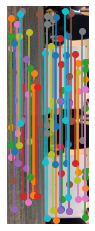

In [32]:
#Modify to show 3D points
plt.imshow(combinedIm)

plt.axis("off")
plt.plot(
    np.vstack([keyPointsIm1[largestInlier, 1], shiftedKeypointsIm2[largestInlier, 1]]),
    np.vstack([keyPointsIm1[largestInlier, 0], shiftedKeypointsIm2[largestInlier, 0]]),
    "-o",
)
plt.savefig("../../Assets/resultsPt2/afterRANSAC_2Tol.jpg", bbox_inches="tight", dpi=1000)